In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
#calibration
def calibration(preds, actuals, groupsize = 10000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, actual, 'k.')
    plt.plot(predicted, predicted, 'r-')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

In [3]:
#training data
from google.colab import drive
drive.mount('/drive')

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw22.csv')

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/data/raw21.csv')

df = pd.concat((raw22, raw21), ignore_index = True)

Mounted at /drive


In [4]:
#one hot encode handedness
pit_hand = pd.get_dummies(df['p_throws'], drop_first = False, dtype = int)
bat_hand = pd.get_dummies(df['stand'], drop_first = False, dtype = int)
df['pit_handR'] = pit_hand['R']
df['bat_handR'] = bat_hand['R']

#remove null values
df.dropna(subset = ['release_speed', 'release_spin_rate', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z'], inplace = True)

#define the pitch outcome
df['outcome'] = -1
df.loc[df.type == 'B', 'outcome'] = 0 #called ball
df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike
df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm
df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball

#the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs
df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice',
                                            'fielders_choice_out', 'double_play', 'other_out', 'triple_play',
                                            'sac_fly_double_play'])), 'outcome'] = 4 # in play out
df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single
df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double
df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple
df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr

#define is_bip
df['is_bip'] = 0
df.loc[df.outcome > 3, 'is_bip'] = 1

#convert movement from feet to inches
df['mx'] = df.pfx_x.values * 12
df['mz'] = df.pfx_z.values * 12

In [5]:
#train the model
features = ['release_speed', 'mx', 'mz', 'plate_x', 'plate_z', 'release_spin_rate', 'bat_handR', 'pit_handR']
model = HistGradientBoostingClassifier().fit(df[features].values, df.is_bip.values)

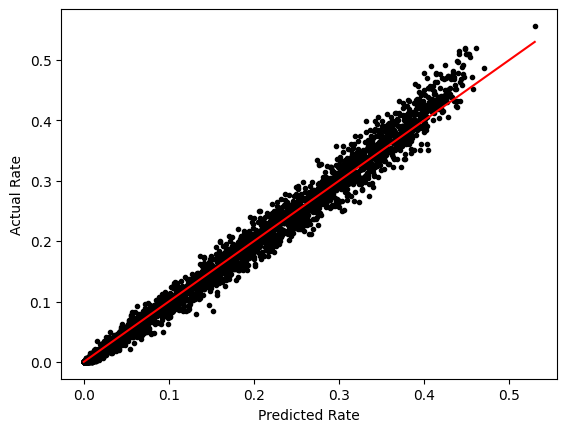

In [6]:
#sanity check
p = model.predict_proba(df[features].values)[:,1]
calibration(p, df.is_bip.values, 500)
plt.show()

In [7]:
#save the model
import pickle
with open('/drive/My Drive/Colab Notebooks/sequencing_positioning_journal_paper/helper_models/is_bip_model.pkl', 'wb') as f:
  pickle.dump(model, f)